In [69]:
import sys
import os
from os import listdir
from pathlib import Path
import shutil

import json
import random
import pandas as pd
from skimage.metrics import structural_similarity as ssim

sys.path.append(os.getcwd()+'/scripts')
import torch
import tensorboard
from pytorch_lightning import Trainer
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from config.config import train_line_parser
from core.models.ModelWrapperSampling import model_wrapper
from Data.data_preparation import DataModule
#from callbacks import WandbTrain_callback
from datetime import datetime

import gc
torch.cuda.empty_cache()
gc.collect()

79582

In [44]:
import importlib
from core.models import ModelWrapperSampling
from core.models.model_parts import Conv_LSTM_Sampling
importlib.reload(Conv_LSTM_Sampling)
importlib.reload(ModelWrapperSampling)
from core.models.ModelWrapperSampling import model_wrapper

### Load configuration

In [45]:
cfg_training = json.load(open(os.getcwd() + "/config/Training.json", 'r'))
model_type = cfg_training['project_name'].split('_')[0]
cfg_model= json.load(open(os.getcwd() + "/config/" + model_type + ".json", 'r'))


### Load dataset

In [46]:
dataset = DataModule(data_dir=cfg_training["pickle_dir"], 
                     train_batch_size=cfg_training["train_batch_size"],
                     val_batch_size=cfg_training["val_batch_size"], 
                     test_batch_size=cfg_training["test_batch_size"], 
                     include_non_pred = cfg_training["include_non_pred"])

### Initialize and train model

In [47]:
model = model_wrapper(model_type, cfg_model, cfg_training)

In [48]:
project_name = cfg_training['project_name']
checkpoint_path = 'GC_checkpoints/{}'.format(project_name)
log_path = 'lightning_logs/{}'.format(project_name)

if os.path.exists(checkpoint_path):
    shutil.rmtree(checkpoint_path, ignore_errors=True)
if os.path.exists(log_path):
    shutil.rmtree(log_path, ignore_errors=True)

checkpoint_callback = ModelCheckpoint(dirpath=checkpoint_path, 
                                      save_on_train_epoch_end=True, 
                                      save_top_k=1,
                                      filename='model_{epoch:03d}')

earlystopping_callback = EarlyStopping(monitor="val_loss", mode="min", patience=cfg_training['patience'])

if cfg_training["early_stopping"]:
    callbacks = [checkpoint_callback, earlystopping_callback]
else:
    callbacks = [checkpoint_callback]

tb_logger = pl_loggers.TensorBoardLogger(save_dir="lightning_logs/{}".format(project_name))

In [49]:
trainer = Trainer(max_epochs=cfg_training["epochs"], 
                  devices=1,
                  accelerator="auto",
                  num_sanity_val_steps=1,
                  check_val_every_n_epoch=1,
                  precision=cfg_training["precision"],
                  logger = tb_logger,
                  log_every_n_steps=5,
                  callbacks=[checkpoint_callback, earlystopping_callback])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [62]:
trainer.fit(model, dataset)

/scratch/rsc8/yongjingm/envs/convlstm/lib/python3.6/site-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name       | Type          | Params
---------------------------------------------
0 | model      | Conv_LSTM     | 342 K 
1 | train_loss | Cube_loss     | 0     
2 | test_loss  | Ensamble_loss | 0     
---------------------------------------------
342 K     Trainable params
0         Non-trainable params
342 K     Total params
1.368     Total estimated model params size (MB)
/scratch/rsc8/yongjingm/envs/convlstm/lib/python3.6/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /scratch/rsc8/yongjingm/Github/ground_cover_convlstm/GC_checkpo

Validation sanity check:   0%|          | 0/1 [00:00<?, ?it/s]

/scratch/rsc8/yongjingm/envs/convlstm/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:662: UserWarning: Your `val_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  category=UserWarning,
/scratch/rsc8/yongjingm/envs/convlstm/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 72 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


/scratch/rsc8/yongjingm/envs/convlstm/lib/python3.6/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `SSIM` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/scratch/rsc8/yongjingm/envs/convlstm/lib/python3.6/site-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  f"DataModule.{name} has already been called, so it will not be called again. "


### VIsualize model results

In [51]:
project_name = cfg_training['project_name']
#project_name = "ConvLSTM_zeros_None"
os.environ['TENSORBOARD_BINARY'] = '/scratch/rsc8/yongjingm/envs/convlstm/bin/tensorboard'
logdir = "lightning_logs/{}/default".format(project_name)
%load_ext tensorboard
%tensorboard --bind_all --logdir $logdir

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Predict

In [70]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import datetime as dt
import glob
from datetime import datetime

#sys.path.append(os.getcwd()+'/demos')
torch.cuda.empty_cache()
gc.collect()

0

In [71]:
import importlib
from Data import data_preparation
importlib.reload(data_preparation)
import importlib
import load_model_data
importlib.reload(load_model_data)
from load_model_data import load_data_point, load_model
project_name = cfg_training['project_name']
#project_name = 'ConvLSTM_zeros_rs'


In [72]:
pred_count = cfg_training['future_training']
train_count = cfg_training['context_training']
total_count = pred_count + train_count
model = load_model(glob.glob('GC_checkpoints/{}/*.ckpt'.format(project_name))[-1]).to('cuda')
truth, context, target, npf, name = load_data_point(cfg_training["pickle_dir"], 'test', cfg_training["include_non_pred"],
                                             context_ratio=train_count/total_count, index=0)

In [73]:
preds = model(truth.to('cuda'), train_count, pred_count, sampling=None).to('cpu')
prediction = preds[..., -pred_count:]

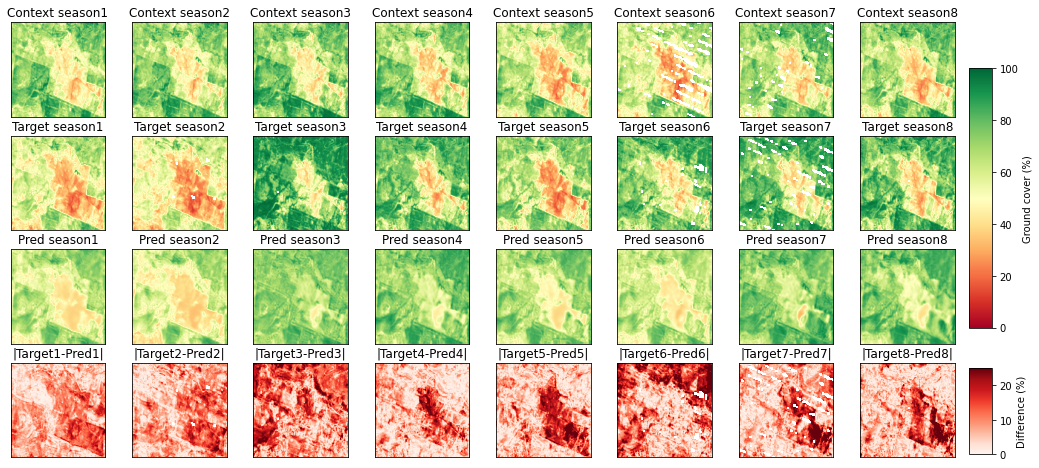

In [74]:
width = 128
height = 128

f, axes = plt.subplots(nrows=4, ncols=pred_count, figsize=(16, 8))
f.subplots_adjust(right=0.95)
cbar_ax1 = f.add_axes([0.96, 0.35, 0.02, 0.45])
cbar_ax2 = f.add_axes([0.96, 0.13, 0.02, 0.15])

for i in range(total_count):
    mask = truth[:, 1, :, :, i].detach().reshape(width, height)
    obs = truth[:, 0, :, :, i].detach().reshape(width, height)
    obs = np.where(mask, np.nan, obs)
    
    if i<train_count:
        ax1 = axes[0, i]
        im1 = ax1.imshow(100-100*obs, vmin=0, vmax=100,  cmap='RdYlGn')
        ax1.set_title('Context season{}'.format(i+1))
        ax1.set_xticks([])
        ax1.set_yticks([])

    else:
        pred = preds[:, :, :, :, i-1].detach().reshape(width, height) 
        ax2 = axes[1, i-train_count]
        ax2.imshow(100-100*obs, vmin=0, vmax=100,  cmap='RdYlGn')
        ax2.set_title('Target season{}'.format(i-train_count+1))
        ax2.set_xticks([])
        ax2.set_yticks([])
        
        ax3 = axes[2, i-train_count]
        ax3.imshow(100-100*pred, vmin=0, vmax=100, cmap='RdYlGn')
        ax3.set_title('Pred season{}'.format(i-train_count+1))
        ax3.set_xticks([])
        ax3.set_yticks([])
        
        ax4 = axes[3, i-train_count]
        im2 = ax4.imshow(100*(np.abs(pred-obs)), vmin=0, vmax=25, cmap='Reds')
        ax4.set_title('|Target{}-Pred{}|'.format(i-train_count+1, i-train_count+1))
        ax4.set_xticks([])
        ax4.set_yticks([])
        
f.patch.set_facecolor('white')
f.colorbar(im1, cax=cbar_ax1)
cbar_ax1.set_ylabel('Ground cover (%)')
f.colorbar(im2, cax=cbar_ax2)
cbar_ax2.set_ylabel('Difference (%)')

if not os.path.exists("Figures"):
    os.mkdir("Figures")
if not os.path.exists("Figures/{}".format(project_name)):
    os.mkdir("Figures/{}".format(project_name))

plt.savefig("Figures/{}/images.jpg".format(project_name))

# Plot time series

In [75]:
# Train
model = model.to('cuda')
path_lists = {
    'train': dataset.training_path_list,
    'val': dataset.validation_path_list,
    'test': dataset.testing_path_list
}

columns = ['Date', 'Label']
for i in range(pred_count):
    columns.append('Obs{}'.format(i+1))
    columns.append('Pred{}'.format(i+1))
    columns.append('MAE{}'.format(i+1))
    columns.append('SSIM{}'.format(i+1))
    columns.append('Cloud{}'.format(i+1))

record_count = len(dataset.training_path_list) +\
len(dataset.validation_path_list) + \
len(dataset.testing_path_list)

df_site = pd.DataFrame(columns=columns, index=range(record_count))

count = 0
for group in path_lists.keys():    
    path_list = path_lists[group]
    for i in range(len(path_list)):
        truth, context, target, npf, name = load_data_point(cfg_training["pickle_dir"], group, cfg_training["include_non_pred"],
                                                     context_ratio=pred_count/(pred_count+train_count), index=i)
        pred_all = model(truth.to('cuda'), train_count, pred_count, sampling=None).to('cpu')
        date = datetime.strptime(name.split('_')[-1], '%Y-%m')
        
        df_site.loc[count, 'Date'] = date
        df_site.loc[count, 'Label'] = group
        
        for j in range(pred_count):            
            mask = truth[:, 1, :, :, train_count+j].detach().reshape(width, height)
            obs = 100-100*truth[:, 0, :, :, train_count+j].detach().reshape(width, height)
            pred = 100-100*pred_all[:, :, :, :, train_count+j-1].detach().reshape(width, height)

            obs = np.where(mask, np.nan, obs)
            pred = np.where(mask, np.nan, pred)
            SSIM = ssim(np.where(np.isnan(obs), 0, obs), np.where(np.isnan(obs), 0, pred))
            MAE = np.nanmean(np.abs(obs-pred))

            df_site.loc[count, 'Obs{}'.format(j+1)] = np.nanmean(obs)
            df_site.loc[count, 'Pred{}'.format(j+1)] = np.nanmean(pred)
            df_site.loc[count, 'SSIM{}'.format(j+1)] = SSIM
            df_site.loc[count, 'MAE{}'.format(j+1)] = MAE
            df_site.loc[count, 'Cloud{}'.format(j+1)] = np.float(mask.sum()/(mask.shape[0]*mask.shape[1]))

        print(date)
        count+=1
        
df_site.sort_values('Date', inplace=True)
    

1992-12-01 00:00:00
1992-06-01 00:00:00
2000-09-01 00:00:00
2006-06-01 00:00:00


/scratch/rsc8/yongjingm/envs/convlstm/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: Mean of empty slice
/scratch/rsc8/yongjingm/envs/convlstm/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: Mean of empty slice
/scratch/rsc8/yongjingm/envs/convlstm/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice


1999-09-01 00:00:00
2001-12-01 00:00:00
2003-03-01 00:00:00
2004-12-01 00:00:00
2003-06-01 00:00:00
2005-09-01 00:00:00
1992-03-01 00:00:00
1994-09-01 00:00:00
1999-12-01 00:00:00
1993-06-01 00:00:00
2002-06-01 00:00:00
1994-03-01 00:00:00
2004-09-01 00:00:00
2000-06-01 00:00:00
1995-03-01 00:00:00
2006-03-01 00:00:00
1995-09-01 00:00:00
1995-12-01 00:00:00
2004-06-01 00:00:00
1998-09-01 00:00:00
2001-09-01 00:00:00
1998-12-01 00:00:00
2002-03-01 00:00:00
2001-06-01 00:00:00
2005-03-01 00:00:00
1999-03-01 00:00:00
2001-03-01 00:00:00
1996-09-01 00:00:00
1995-06-01 00:00:00
1998-03-01 00:00:00
1993-12-01 00:00:00
1997-06-01 00:00:00
1993-09-01 00:00:00
1994-06-01 00:00:00
1996-06-01 00:00:00
2004-03-01 00:00:00
1997-12-01 00:00:00
2003-09-01 00:00:00
2005-12-01 00:00:00
1997-03-01 00:00:00
2006-09-01 00:00:00
1992-09-01 00:00:00
2000-12-01 00:00:00
1998-06-01 00:00:00
2002-09-01 00:00:00
1999-06-01 00:00:00
1996-03-01 00:00:00
1994-12-01 00:00:00
2002-12-01 00:00:00
2003-12-01 00:00:00


Test MAE: 6.926
Test SSIM: 0.705


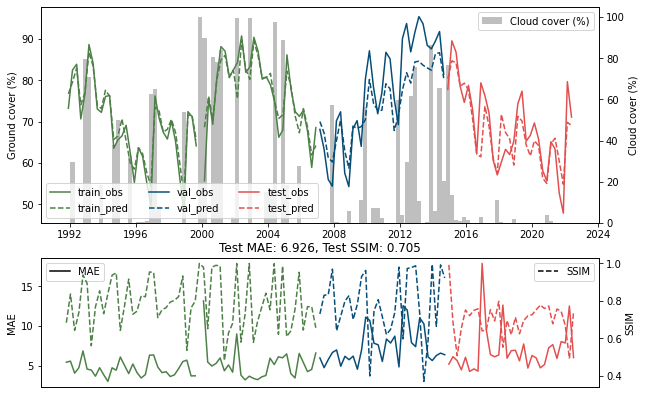

In [79]:
colors = {'train':'#4d8047', 'val':'#064e78', 'test':'#e34f4f'}

f, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 7), gridspec_kw={'height_ratios': [2, 1.2]})
ax1 = axes[0]
ax2 = ax1.twinx()
ax3 = axes[1]
ax4 = ax3.twinx()
for group in colors.keys():
    idx = (df_site['Label']==group)
    ax1.plot(df_site.loc[idx, 'Date'], df_site.loc[idx, 'Obs1'], 
             color=colors[group], linestyle='-', label='{}_obs'.format(group))
    ax1.plot(df_site.loc[idx, 'Date'], df_site.loc[idx, 'Pred1'],
             color=colors[group], linestyle='--',  label='{}_pred'.format(group))
    if group == 'train':
        
        label = 'Cloud cover (%)'
    else:
        label = ''
    ax2.bar(df_site.loc[idx, 'Date'], df_site.loc[idx, 'Cloud1']*100,
            width=0.5*(df_site['Date'][1]-df_site['Date'][0]), zorder=-1, 
            color='grey', alpha=0.5, label=label)
    ax3.plot(df_site.loc[idx, 'Date'], df_site.loc[idx, 'MAE1'],
             color=colors[group], linestyle='-')
    ax4.plot(df_site.loc[idx, 'Date'], df_site.loc[idx, 'SSIM1'],
             color=colors[group], linestyle='--')

ax1.legend(ncol=3)
ax1.set_ylabel('Ground cover (%)')
ax1.set_zorder(2)
ax1.set_facecolor("none")
ax2.set_zorder(1)
ax2.set_ylabel('Cloud cover (%)')
ax2.legend()
#ax2.set_yscale('log')
ax3.set_ylabel('MAE')
ax3.plot([], [], linestyle='-', color='k', label='MAE')
ax3.legend(loc=2, ncol=1)
ax3.set_xticks([])
ax4.set_ylabel('SSIM')
ax4.plot([], [], linestyle='--', color='k', label='SSIM')
ax4.legend(loc=1, ncol=1)

test_MAE = np.mean(df_site.loc[df_site['Label']=='test', 'MAE1'])
test_SSIM = np.mean(df_site.loc[df_site['Label']=='test', 'SSIM1'])
print("Test MAE: {:.3f}".format(test_MAE))
print("Test SSIM: {:.3f}".format(test_SSIM))
ax4.set_title("Test MAE: {:.3f}, Test SSIM: {:.3f}".format(test_MAE, test_SSIM))
plt.savefig("Figures/{}/timeseries.jpg".format(project_name))